In [1]:
import math
import sys

import IPython
import IPython.display as ipd
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

%matplotlib inline
#%matplotlib notebook

from matplotlib import rcParams
import matplotlib.font_manager

# print([k for k in rcParams.keys() if "figure" in k])
plt.rcParams.update(
    {
        "figure.figsize": (10, 5),
        "figure.max_open_warning": False,
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica"],
    }
)

In [2]:
sys.path.append("../crazyflie-audio/python/")
from bin_selection import select_frequencies
from crazyflie_description_py.parameters import N_BUFFER, FS, FFTSIZE

DURATION_PER_FREQ = 0.5
DURATION_SEC = DURATION_PER_FREQ * FFTSIZE


def buzzer_signal(source):
    from signals import generate_signal

    kwargs = dict(duration_sec=DURATION_SEC, max_dB=-10, Fs=FS,)
    frequencies = np.fft.rfftfreq(N_BUFFER, 1 / FS)
    if source == "mono4125":
        return generate_signal(signal_type="mono", frequency_hz=4125, **kwargs)
    elif source == "random":
        return generate_signal(signal_type="random", **kwargs)
    elif source == "multi":
        phase = np.random.uniform(0, 2 * np.pi)
        signal = generate_signal(
            signal_type="mono",
            frequency_hz=frequencies[1],
            **kwargs,
            phase_offset=phase,
        )
        for f in frequencies[2:]:
            phase = np.random.uniform(0, 2 * np.pi)
            signal += generate_signal(
                signal_type="mono", frequency_hz=f, **kwargs, phase_offset=phase
            )
        return signal
    elif source == "sweep":
        # duration of each frequency bin
        min_freq = 100
        max_freq = 4400

        bins = select_frequencies(
            n_buffer=N_BUFFER, fs=FS, min_freq=min_freq, max_freq=max_freq
        )

        duration_all = len(bins) * duration_per_freq
        signal = np.zeros(int(FS * duration_all))
        idx = 0
        for f in frequencies[bins]:

            kwargs["duration_sec"] = duration_per_freq
            mono = generate_signal(signal_type="mono", frequency_hz=f, **kwargs)
            signal[idx : idx + len(mono)] = mono
            idx += len(mono)
        return signal
    else:
        raise ValueError(source)


signals = {}
for key in ["mono4125", "random", "multi", "sweep"]:
    try:
        signal = pd.read_pickle(f"results/{key}.pk")
        print(f"read {key}")
    except:
        signal = buzzer_signal(key)
        pd.to_pickle(signal, f"results/{key}.pk")
        print(f"saved {key}")
    signals[key] = signal

read mono4125
read random
read multi
read sweep


In [3]:
def matrix_slices(
    df_matrix,
    frequencies,
    distances,
    saveas="",
    ymin=None,
    ymax=None,
    start_freq=1000,
    start_dist=30,
):
    from ipywidgets import (
        interact,
        interactive,
        fixed,
        interact_manual,
        FloatSlider,
        IntSlider,
    )
    import ipywidgets as widgets
    from plotting_tools import save_fig

    def update_figure(slice_f, slice_d):
        fig, axs = plt.subplots(1, 2)
        fig.set_size_inches(10, 5)
        # axs[0].semilogy(distances, df_matrix[slice_f, :])
        axs[0].plot(distances, df_matrix[slice_f, :])
        axs[0].set_title(f"frequency = {frequencies[slice_f]:.0f} Hz")
        axs[0].set_xlabel("distance [cm]")
        axs[0].set_ylabel("amplitude [-]")
        axs[0].set_ylim(ymin, ymax)

        # axs[1].semilogy(frequencies, df_matrix[:, slice_d])
        axs[1].plot(frequencies, df_matrix[:, slice_d])
        axs[1].set_title(f"distance = {distances[slice_d]:.0f} cm")
        axs[1].set_xlabel("frequency [Hz]")
        axs[1].set_ylabel("amplitude [-]")
        axs[1].set_ylim(ymin, ymax)
        if saveas != "":
            save_fig(fig, saveas)
        plt.show()

    start_freq_index = np.argmin(np.abs(start_freq - frequencies))
    start_dist_index = np.argmin(np.abs(start_dist - distances))
    interactive_plot = interact(
        update_figure,
        slice_f=IntSlider(
            start_freq_index, min=0, max=len(frequencies) - 1, continuous_update=False
        ),
        slice_d=IntSlider(
            start_dist_index, min=0, max=len(distances) - 1, continuous_update=False
        ),
    )

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


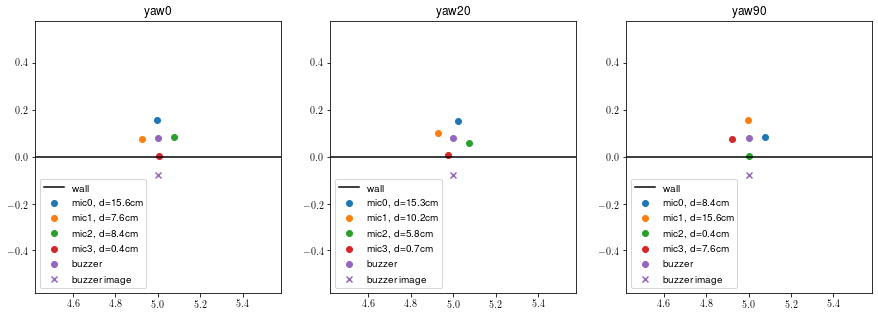

In [4]:
from simulation import generate_room

angles = [0, 20, 90]
fig, axs = plt.subplots(1, len(angles), squeeze=False)
fig.set_size_inches(5 * len(angles), 5)
for ax, angle in zip(axs.flatten(), angles):
    room = generate_room(distance_cm=0, yaw_deg=angle, ax=ax)
    ax.set_title(f"yaw{angle}")
    ax.legend(loc="lower left")

(-8.168216612506114, 10.865153172024103, -8.033369784530215, 8.033369784530215)

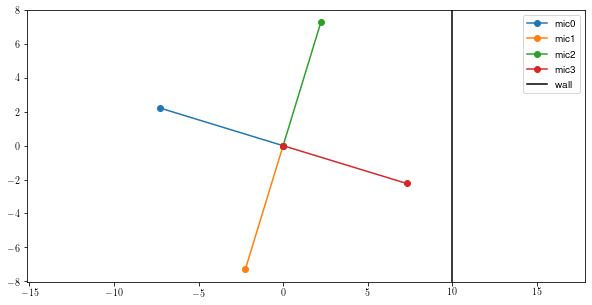

In [5]:
from simulation import get_df_theory_simple, get_deltas_from_global

fig, ax = plt.subplots()
for i in range(4):
    deltas = get_deltas_from_global(20, 0, i, ax)
ax.axvline(10, color="black", label="wall")
ax.legend()
ax.axis("equal")

# Distance-frequency matrix

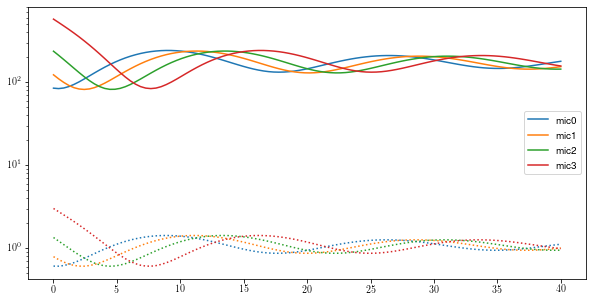

In [6]:
from simulation import get_dist_slice_pyroom, get_dist_slice_theory

yaw_deg = 20
distances_cm = np.linspace(0, 40, 100)
frequency = 1000

Hs = get_dist_slice_pyroom(frequency, distances_cm=distances_cm, yaw_deg=yaw_deg)
Hs_theo = get_dist_slice_theory(frequency, distances_cm=distances_cm, yaw_deg=yaw_deg)
fig, ax = plt.subplots()
for i in range(Hs.shape[1]):
    ax.plot(distances_cm, Hs[:, i], label=f"mic{i}", ls="-", color=f"C{i}")
    ax.plot(distances_cm, Hs_theo[:, i], ls=":", color=f"C{i}")
ax.set_yscale("log")
ax.legend()

[0.2, 12.72222779205292, -0.2518620780029936]
[0.2, 12.804820495885053, -0.37152794306311127]


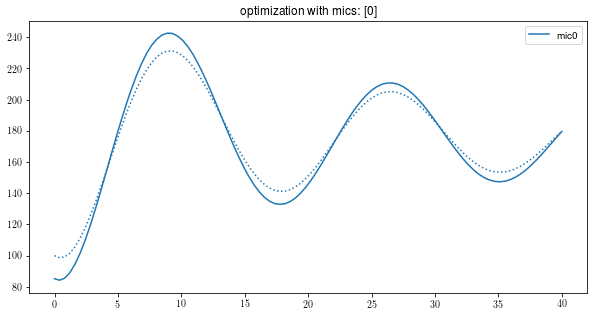

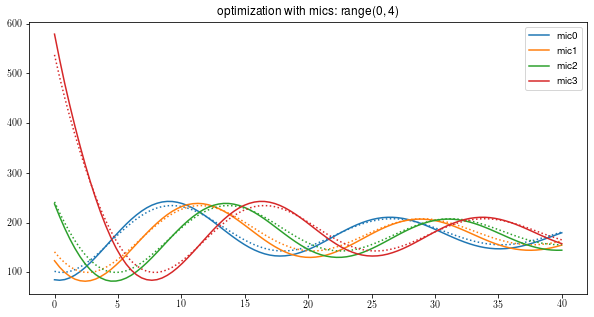

In [7]:
from calibration import fit_distance_slice

for chosen_mics in [[0], range(4)]:
    coeffs, d_slice, cost = fit_distance_slice(
        Hs, distances_cm, yaw_deg, frequency, chosen_mics
    )
    print(coeffs)
    fig, ax = plt.subplots()
    for i, mic in enumerate(chosen_mics):
        ax.plot(distances_cm, Hs[:, i], label=f"mic{mic}", ls="-", color=f"C{mic}")
        ax.plot(distances_cm, d_slice[:, i], ls=":", color=f"C{mic}")
    ax.legend()
    ax.set_title(f"optimization with mics: {chosen_mics}")

In [8]:
from simulation import get_freq_slice_pyroom
import progressbar

mic_idx = 1
distances = np.linspace(0, 60, 100)
frequencies = np.fft.rfftfreq(N_BUFFER, 1 / FS)

fname = "results/df_matrix_pyroom.pkl"
try:
    series_all = pd.read_pickle(fname)
    print("read", fname)
    np.testing.assert_allclose(series_all.distances, distances)
    np.testing.assert_allclose(series_all.frequencies, frequencies)
    df_matrix = series_all.df_matrix
except Exception as e:
    print(e)
    df_matrix = np.zeros((len(frequencies), len(distances)))

    signal = signals["multi"]
    with progressbar.ProgressBar(max_value=len(distances) - 1) as bar:
        for j, distance_cm in enumerate(distances):
            slice_mics = get_freq_slice_pyroom(frequencies, distance_cm, signal=signal)
            df_matrix[:, j] = slice_mics[mic_idx]
            bar.update(j)
    series = pd.Series(
        {"df_matrix": df_matrix, "distances": distances, "frequencies": frequencies}
    )
    pd.to_pickle(series, fname)
    print("saved as", fname)

read results/df_matrix_pyroom.pkl


In [9]:
min_freq = 100
max_freq = 5000
min_dist = 1
max_dist = 50
freq_start = int(min_freq / max(frequencies) * len(frequencies))
freq_end = int(max_freq / max(frequencies) * len(frequencies))
dist_start = int(min_dist / max(distances) * len(distances))
dist_end = int(max_dist / max(distances) * len(distances))

dist = distances[dist_start:dist_end]
freq = frequencies[freq_start:freq_end]

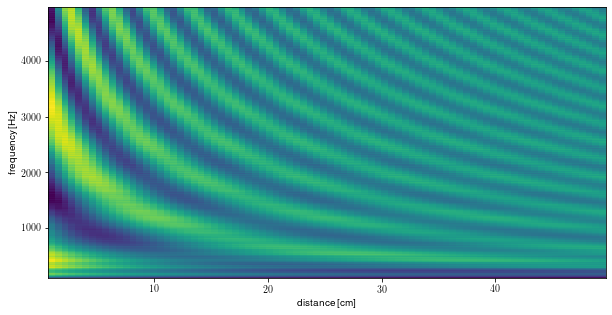

interactive(children=(IntSlider(value=58, continuous_update=False, description='slice_f', max=313), IntSlider(…

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.pcolorfast(dist, freq, df_matrix[freq_start:freq_end, dist_start:dist_end])
plt.xlabel("distance [cm]")
plt.ylabel("frequency [Hz]")
matrix_slices(
    df_matrix[freq_start:freq_end, dist_start:dist_end], freq, dist, ymin=8, ymax=20,
)

In [11]:
from simulation import get_freq_slice_theory

df_matrix_theo = np.empty((len(frequencies), len(distances)))
for j, distance_cm in enumerate(distances):
    slice_mics = get_freq_slice_theory(frequencies, distance_cm)
    df_matrix_theo[:, j] = slice_mics[:, mic_idx]

saved as plots/distance-frequency-matrix.pdf


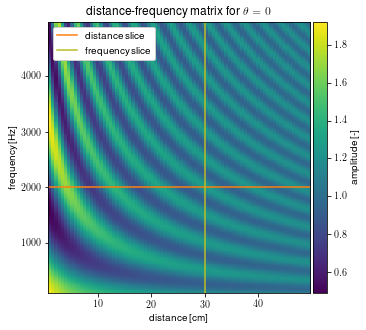

interactive(children=(IntSlider(value=122, continuous_update=False, description='slice_f', max=313), IntSlider…

In [12]:
from plotting_tools import save_fig, add_colorbar

start_freq = (2000,)
start_dist = (30,)
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
im = ax.pcolorfast(dist, freq, df_matrix_theo[freq_start:freq_end, dist_start:dist_end])
add_colorbar(fig, ax, im, title="amplitude [-]")
ax.set_title("distance-frequency matrix for $\\theta=0$")
ax.axhline(start_freq, color="C1", label="distance slice")
ax.axvline(start_dist, color="C8", label="frequency slice")
ax.legend(framealpha=1.0)
ax.set_xlabel("distance [cm]")
ax.set_ylabel("frequency [Hz]")
save_fig(fig, "plots/distance-frequency-matrix.pdf")

matrix_slices(
    df_matrix_theo[freq_start:freq_end, dist_start:dist_end],
    freq,
    dist,
    start_freq=start_freq,
    start_dist=start_dist,
    saveas="plots/distance-frequency-slices.pdf",
)

### vertical frequency slice

max attainable delta: 132.91250000000002
max attainable distance: 62.37093701305632


TypeError: get_probability_fft() got an unexpected keyword argument 'window'

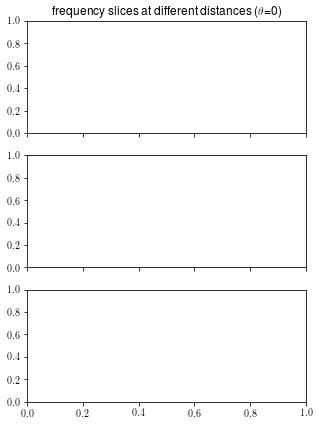

In [13]:
from wall_detector import (
    get_probability_cost,
    get_probability_fft,
    get_probability_bayes,
)
from simulation import get_deltas_from_global, SPEED_OF_SOUND

# distance_slices = [5, 10, 20, 30, 40, 50]


window = None  #'hann' #('tukey', 0.2) #None
min_frequency = 1000
max_frequency = 5000
n_freqs = 32
freq_cont = np.linspace(min_frequency, max_frequency, 1000)
freq = np.linspace(min_frequency, max_frequency, n_freqs)

distances_grid = np.linspace(0, 100, 100)
n_max = 100  # for zero-padding

# highest frequency that we can resolve
df = freq[1] - freq[0]
delta_max = SPEED_OF_SOUND / (2 * df) * 100
print("max attainable delta:", delta_max)
from simulation import get_orthogonal_distance_from_global
d = get_orthogonal_distance_from_global(
    deltas_cm=delta_max, yaw_deg=0, mic_idx=mic_idx
)[0]
print("max attainable distance:", d)

distance_slices = [30, d, 80]
#sigma_y = 1 # works with 1e-1, 1e-2: really good! with 1, it breaks down.
for sigma_y in [0] + list(np.logspace(-3, 0, 4)):
    size = (5, 7)
    fig_all, axs = plt.subplots(len(distance_slices), sharey=True, sharex=True)
    axs[0].set_title("frequency slices at different distances ($\\theta$=0)")
    fig_all.set_size_inches(*size)
    for i, d in enumerate(distance_slices):
        idx = np.argmin(np.abs(distances - d))
        slice_cont = get_freq_slice_theory(distance_cm=d, frequencies=freq_cont)[:, mic_idx]
        slice_f = get_freq_slice_theory(distance_cm=d, frequencies=freq)[:, mic_idx]

        slice_f += np.random.normal(scale=sigma_y, size=len(slice_f))

        d_fft, p_fft = get_probability_fft(slice_f, freq, window=window, n_max=n_max)
        p_cost = get_probability_cost(slice_f, freq, distances_grid)
        d_bayes_sigma, p_bayes_sigma = get_probability_bayes(
            slice_f, freq, window=window, n_max=n_max, sigma=sigma_y  # n_max
        )
        d_bayes, p_bayes = get_probability_bayes(
            slice_f, freq, window=window, n_max=n_max  # n_max
        )

        axs[i].set_ylabel("amplitude [-]")
        axs[i].plot(freq_cont, slice_cont, label=f"{d:.0f}cm", color="C0")
        axs[i].scatter(freq, slice_f, color="C0")
        axs[i].legend(loc="upper right")

        fig = plt.figure()
        fig.set_size_inches(*size)
        plt.plot(d_fft, p_fft, marker="o", label="FFT")
        plt.plot(d_bayes, p_bayes, marker="x", label="Bayes")
        plt.plot(d_bayes_sigma, p_bayes_sigma, marker=".", label="Bayes, known sigma")
        plt.plot(distances_grid, p_cost, marker="o", label="optimization")
        plt.axvline(d, ls=":", color="black", label="real distance")
        plt.title(f"probabilities at distance {d:.0f}cm ($\\theta$=0)")
        plt.ylabel("probability [-]")
        plt.xlim(min(distances_grid), max(distances_grid))
        plt.legend(loc="lower right")
        # plt.ylim(0, 1)
        plt.yscale("log")
        plt.xlabel("orthogonal distance [cm]")
        plt.ylim(1e-6, 1)
        save_fig(fig, f"plots/simulation/study_fslice_{d:.0f}_{str(sigma_y).replace('.','-')}.pdf")
    axs[i].set_xlabel("frequency [Hz]")
    print("max distance", d_fft[-1])
    save_fig(fig_all, f"plots/simulation/study_fslices_{str(sigma_y).replace('.','-')}.pdf")

### non-vertical frequency slice

In [ ]:
nominal_distance = 10
nominal_yaw = 0
relative_distances = np.random.normal(0, 1, len(freq))
absolute_yaws = np.random.normal(0, 1, len(freq))

deltas, d0 = get_deltas_from_global(
    yaw_deg=nominal_yaw, distances_cm=distances, mic_idx=mic_idx
)
nominal_delta, d0 = get_deltas_from_global(nominal_yaw, nominal_distance, mic_idx)
deltas_noisy, d0 = get_deltas_from_global(
    nominal_yaw + absolute_yaws, nominal_distance + relative_distances, mic_idx
)

fig, ax = plt.subplots()
ax.pcolorfast(deltas, frequencies, df_matrix_theo[:-1, :-1])
ax.axvline(nominal_delta, color="C1")
ax.scatter(deltas_noisy, freq, color="C1")
ax.set_ylim(min(freq), max(freq))

df_vert = get_df_theory_simple(nominal_delta, freq)
slice_f_vert = df_vert.flatten()

df = get_df_theory_simple(deltas_noisy, freq)
slice_f = np.diag(df)

plt.figure()
plt.plot(freq, slice_f_vert, label="vertical")
plt.plot(freq, slice_f, label="noisy")
plt.legend()

probs_rel = get_probability_cost(
    slice_f,
    freq,
    distances_grid,
    relative_ds=relative_distances,
    absolute_yaws=absolute_yaws,
)
probs = get_probability_cost(slice_f, freq, distances_grid)
plt.figure()
plt.plot(distances_grid, probs, label="ignore mvmt")
plt.plot(distances_grid, probs_rel, label="account for mvmt")
plt.yscale("log")
plt.legend()

### distance slice

Values bigger than 1: 326/501
Values bigger than 1: 326/501
Values bigger than 1: 326/501
Values bigger than 1: 326/501


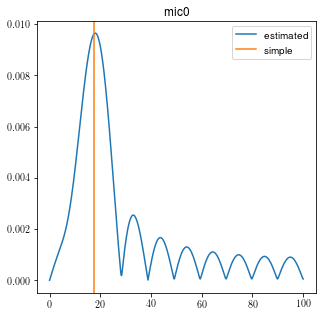

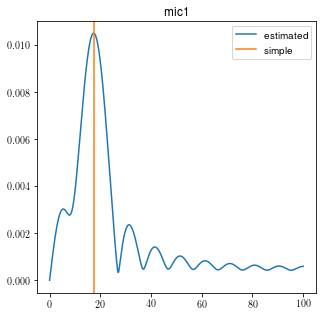

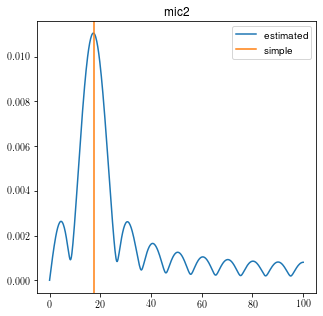

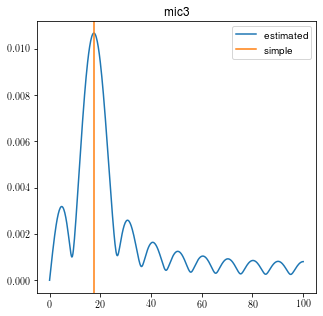

In [34]:
from wall_detector import get_approach_angle_fft
from simulation import factor_distance_to_delta
yaw_deg = 20
n_methods = 2

gamma_deg = 30

frequency = 3000
relative_distances_cm = np.arange(20, step=1.0)
start_distance_cm = 20

start_distances_grid = [start_distance_cm] #np.arange(40, 60)
gammas_grid = np.arange(91)
n_max = 1000

distances_cm = start_distance_cm - relative_distances_cm * np.sin(
    gamma_deg / 180 * np.pi
)
for mic_idx in range(4):
    deltas_m, d0 = get_deltas_from_global(yaw_deg, distances_cm, mic_idx)

    slice_d = get_df_theory_simple(deltas_m, [frequency], flat=True, d0=d0)

    gammas, probs, periods = get_approach_angle_fft(
        slice_d,
        frequency,
        relative_distances_cm,
        n_max=n_max,
    )

    period_simple = 2 * frequency / SPEED_OF_SOUND

    fig = plt.figure()
    plt.plot(periods/np.sin(gamma_deg/180*np.pi), 
             probs, 
             label='estimated', 
             color='C0')
    plt.axvline(period_simple, label='simple', color='C1')
    fig.set_size_inches(5, 5)
    plt.title(f'mic{mic_idx}')
    plt.legend()

distances: 1.000e-02 m, range: 0.19 m
usable freqs: 3611 - 34300 Hz
ground truth: 90
Values bigger than 1: 382/501
Values bigger than 1: 382/501
Values bigger than 1: 382/501
saved as plots/simulation/study_dslice_90_2000_0.pdf
Values bigger than 1: 322/501
Values bigger than 1: 322/501
Values bigger than 1: 322/501
saved as plots/simulation/study_dslice_90_3000_0.pdf
Values bigger than 1: 263/501
Values bigger than 1: 263/501
Values bigger than 1: 263/501
saved as plots/simulation/study_dslice_90_4000_0.pdf
distances: 8.660e-03 m, range: 0.1645448267190433 m
usable freqs: 4169 - 39606 Hz
ground truth: 60
Values bigger than 1: 382/501
Values bigger than 1: 382/501
Values bigger than 1: 382/501
saved as plots/simulation/study_dslice_60_2000_0.pdf
Values bigger than 1: 322/501
Values bigger than 1: 322/501
Values bigger than 1: 322/501
saved as plots/simulation/study_dslice_60_3000_0.pdf
Values bigger than 1: 263/501
Values bigger than 1: 263/501
Values bigger than 1: 263/501
saved as pl

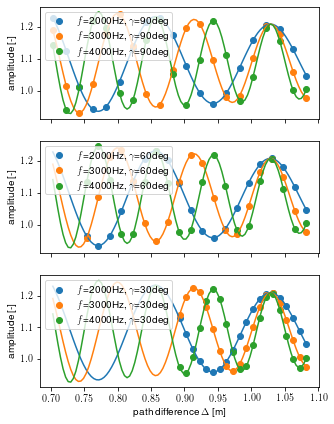

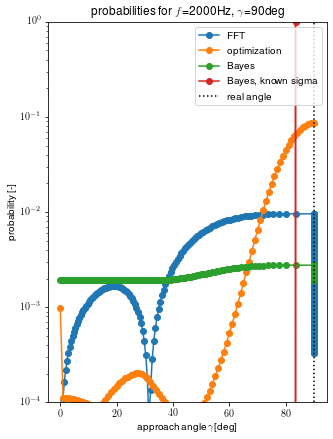

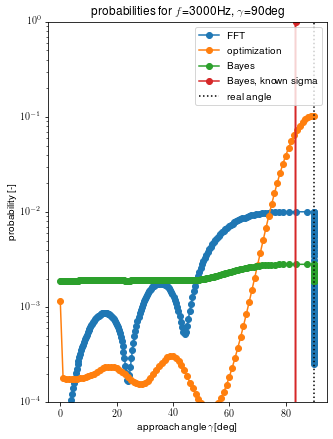

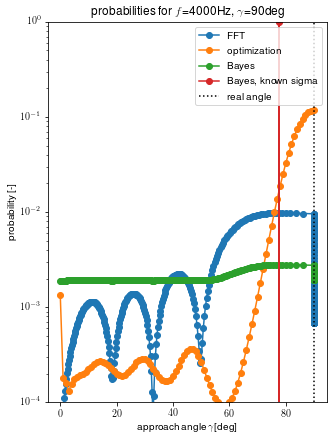

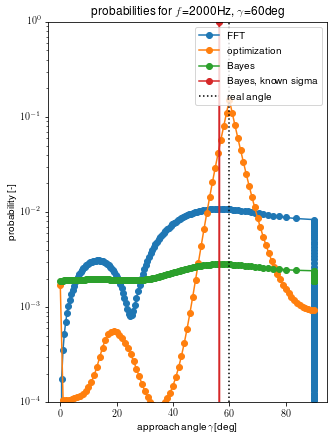

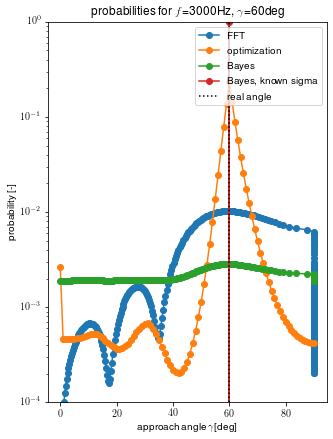

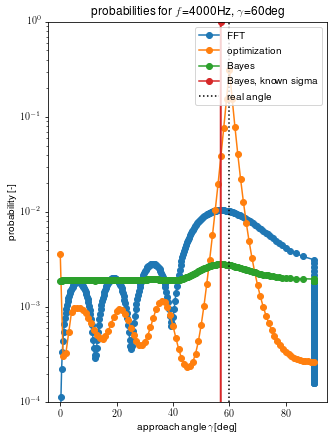

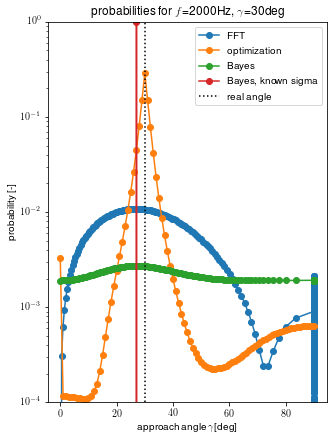

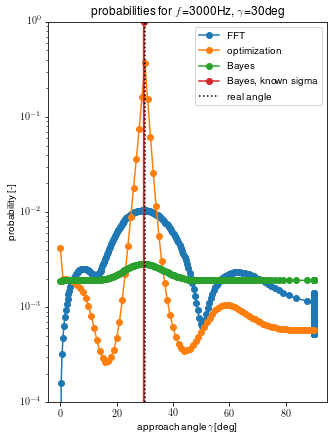

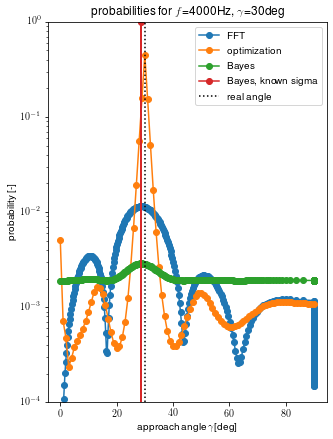

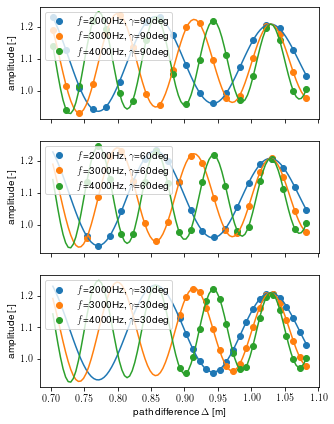

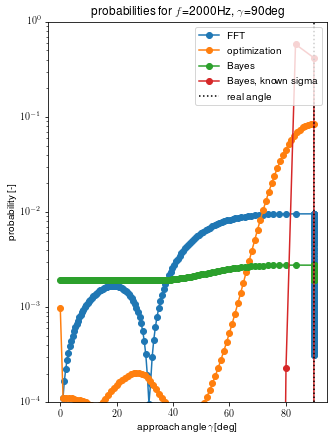

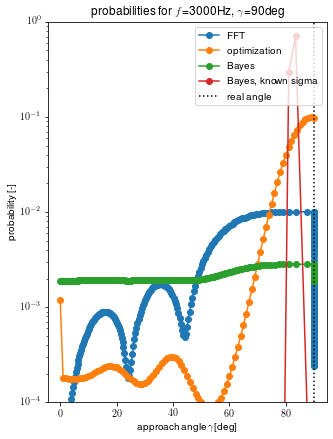

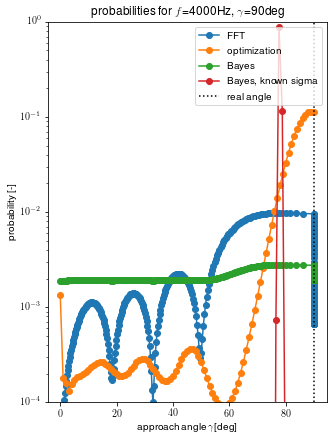

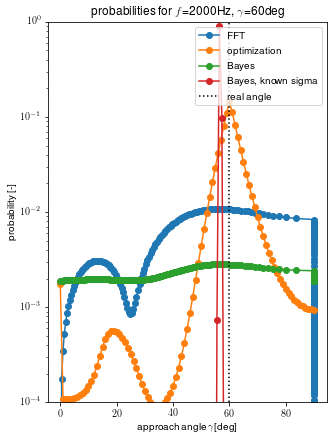

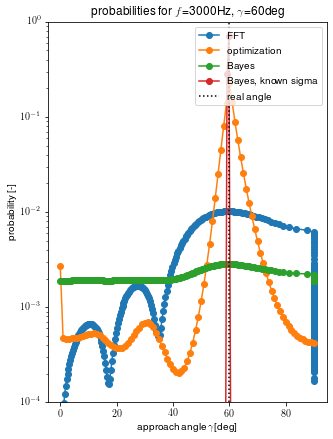

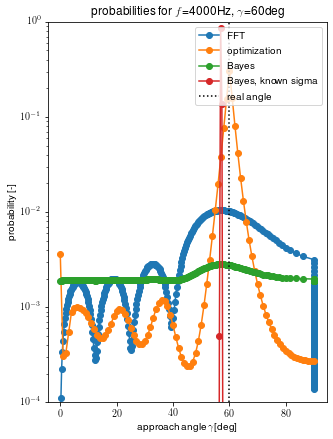

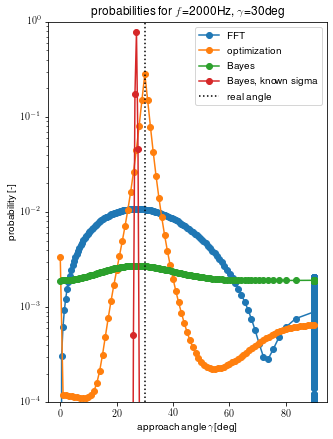

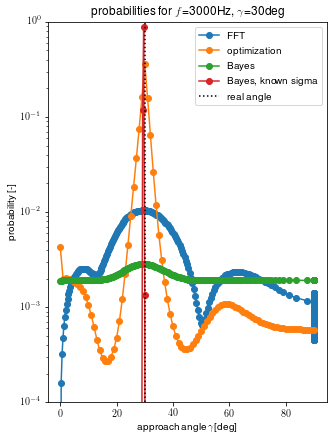

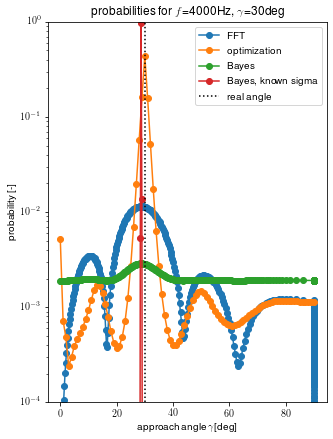

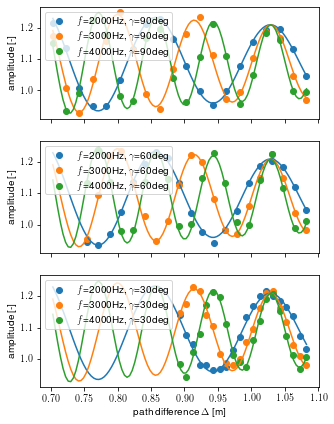

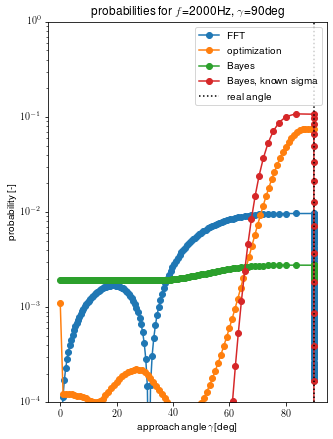

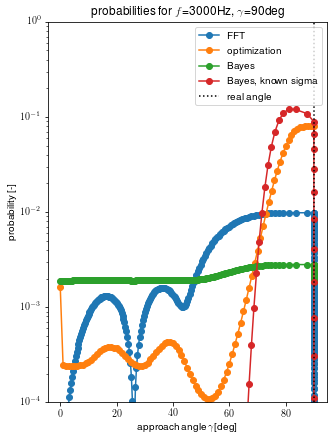

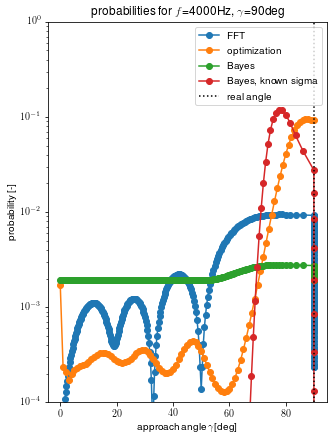

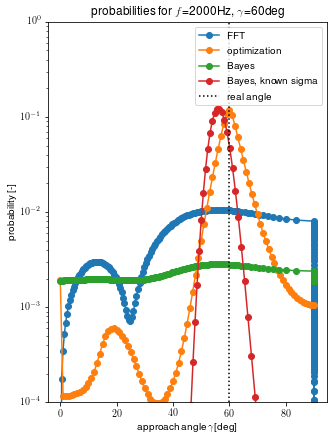

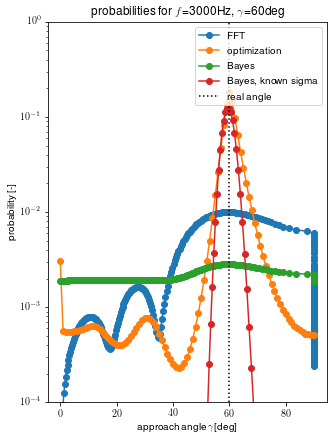

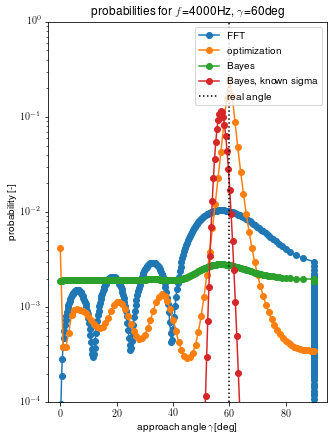

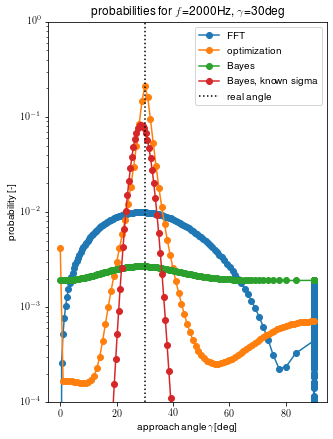

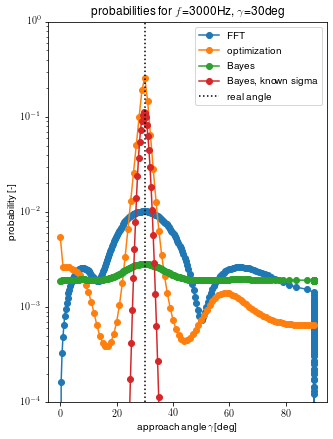

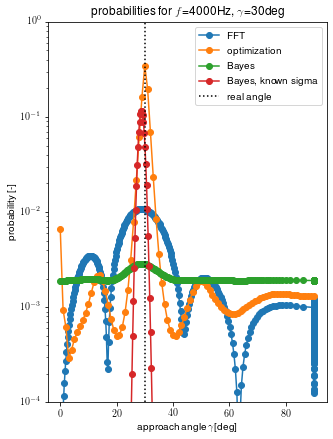

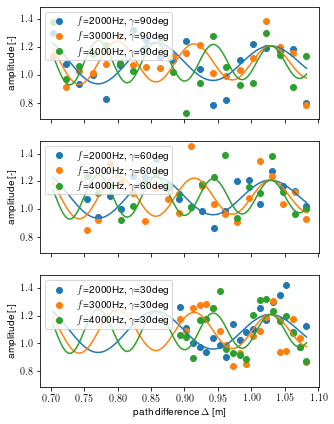

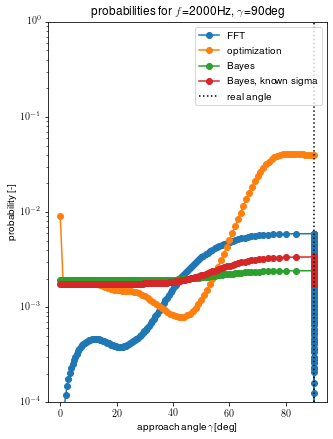

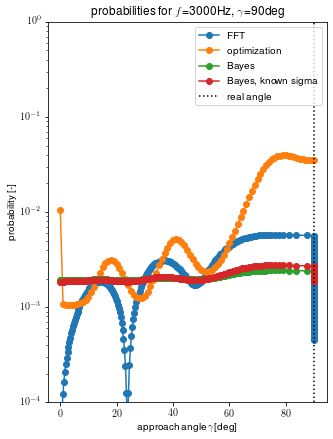

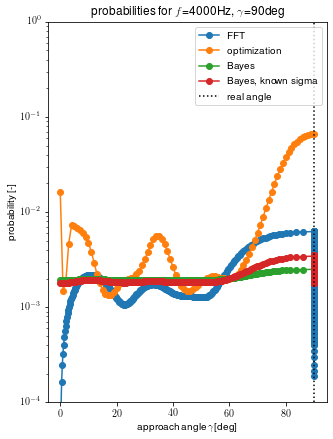

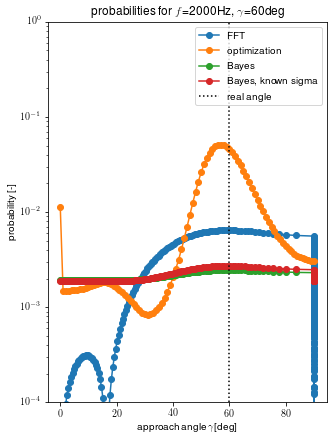

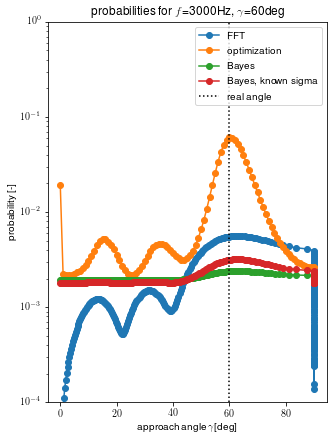

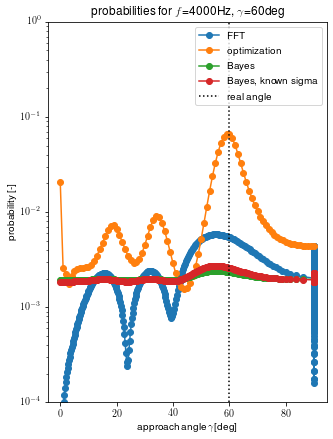

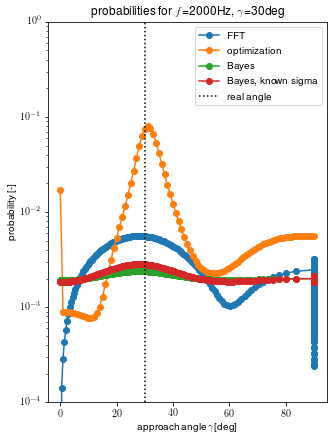

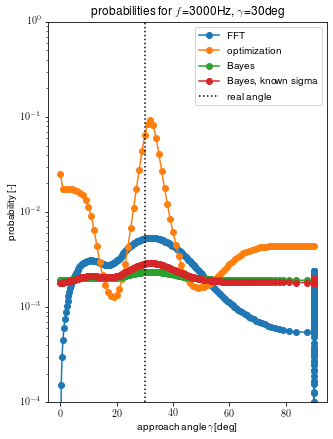

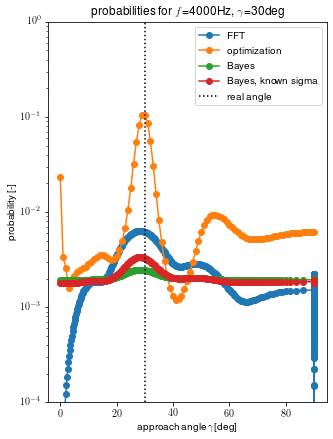

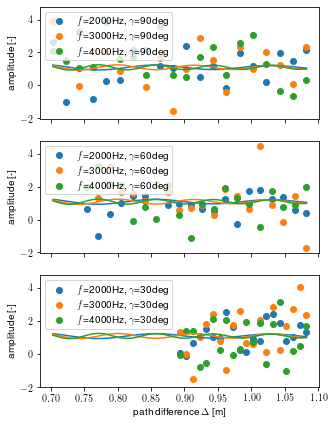

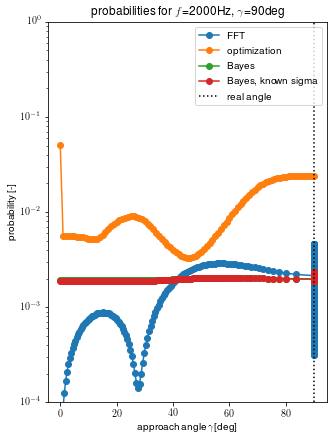

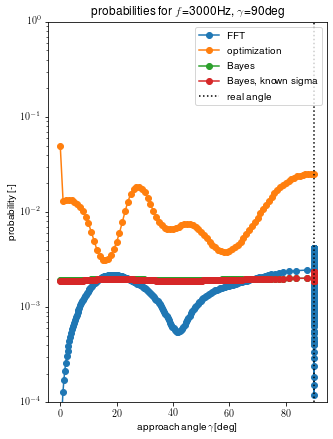

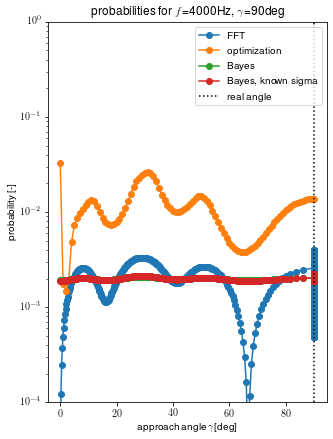

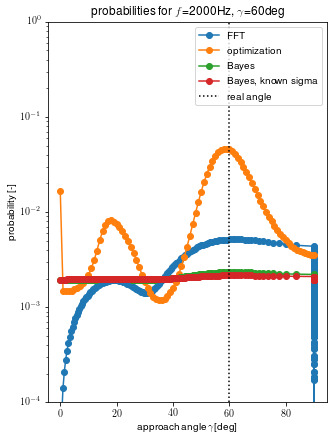

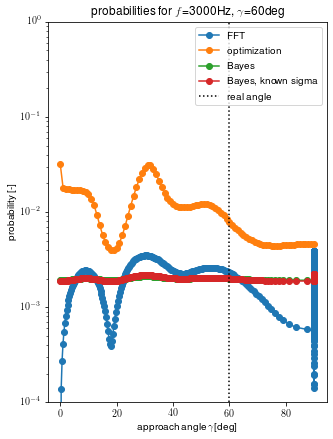

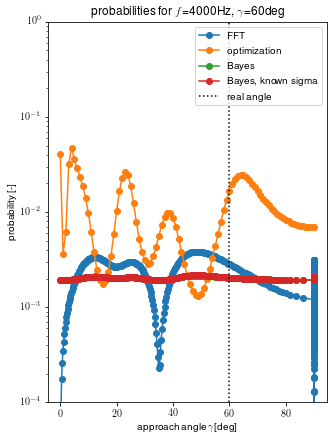

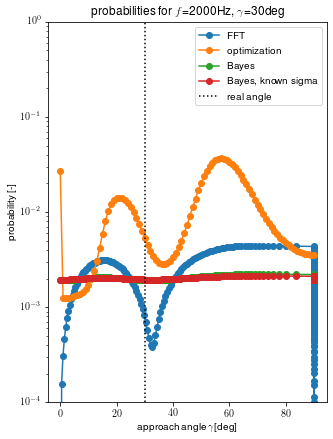

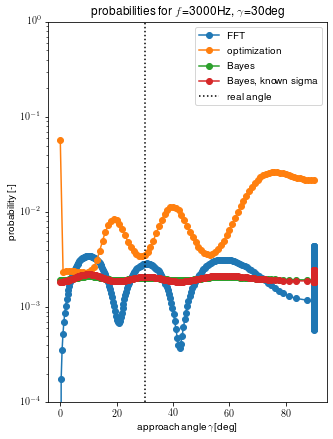

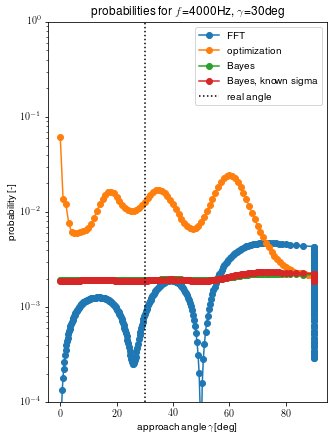

In [15]:
import itertools
from wall_detector import get_approach_angle_fft, get_approach_angle_cost
from simulation import get_orthogonal_distance_from_global

yaw_deg = 0
mic_idx = 1
n_methods = 2

gammas_deg = [90, 60, 30]
freqs = np.linspace(2000, 4000, 3)
relative_distances_cm = np.arange(20, step=1.0)
start_distance_cm = 50

start_distances_grid = [50] #np.arange(40, 60)
gammas_grid = np.arange(91)

sigma_relative_cm = 0 #1e-5 #1e-5
n_max = 1000

distances_max = np.linspace(start_distance_cm-max(relative_distances_cm), start_distance_cm, 100)
deltas_max, d0 = get_deltas_from_global(yaw_deg, distances_max, mic_idx)

sigma_y = 1e-2 #0 
for sigma_y in [0] + list(np.logspace(-3, 0, 4)):
    size = (5, 7)
    fig_slices, ax_slices = plt.subplots(len(gammas_deg), sharex=True, sharey=True)
    fig_slices.set_size_inches(*size)

    for i_gamma, gamma_deg in enumerate(gammas_deg):
        distances_cm = start_distance_cm - relative_distances_cm * np.sin(
            gamma_deg / 180 * np.pi
        )
        deltas_m, d0 = get_deltas_from_global(yaw_deg, distances_cm, mic_idx)

        d_m = np.abs(np.mean(np.diff(distances_cm))) * 1e-2
        D_m = (np.max(distances_cm) - np.min(distances_cm)) * 1e-2
        print(f"distances: {d_m:.3e} m, range: {D_m} m")
        print(
            f"usable freqs: {2*SPEED_OF_SOUND/D_m:.0f} - {SPEED_OF_SOUND/d_m:.0f} Hz"
        )

        print("ground truth:", gamma_deg)


        for i_freq, frequency in enumerate(freqs):
            label = f"$f$={frequency:.0f}Hz, $\\gamma$={gamma_deg}deg"
            slice_d = get_df_theory_simple(deltas_m, [frequency], flat=True, d0=d0)
            slice_d += np.random.normal(scale=sigma_y, size=len(slice_d))

            # plotting
            slice_cont = get_df_theory_simple(deltas_max, [frequency], flat=True, d0=d0)
            ax_slices[i_gamma].plot(deltas_max, slice_cont, color=f"C{i_freq}")
            ax_slices[i_gamma].scatter(deltas_m, slice_d, label=label, color=f"C{i_freq}")

            gammas_bayes, probs_bayes = get_approach_angle_fft(
                slice_d,
                frequency,
                relative_distances_cm,
                n_max=n_max,
                bayes=True,
                sigma=None,
            )
            gamma_bayes = gammas_bayes[np.argmax(probs_bayes)]
            gammas_bayes_sigma, probs_bayes_sigma = get_approach_angle_fft(
                slice_d,
                frequency,
                relative_distances_cm,
                n_max=n_max,
                bayes=True,
                sigma=sigma_y,
            )
            gamma_bayes_sigma = gammas_bayes_sigma[np.argmax(probs_bayes_sigma)]

            gammas_fft, probs_fft = get_approach_angle_fft(
                slice_d,
                frequency,
                relative_distances_cm,
                n_max=n_max,
                bayes=False,
                sigma=sigma_y,
            )
            gamma_fft = gammas_fft[np.argmax(probs_fft)]

            probs_cost = get_approach_angle_cost(
                slice_d,
                frequency,
                relative_distances_cm,
                start_distances_grid,
                gammas_grid,
                mic_idx=mic_idx,
                # ax=ax,
            )  # is of shape n_start_distances x n_gammas_grid

            #fig, ax = plt.subplots()
            #ax.pcolorfast(start_distances_grid, gammas_grid, probs_cost.T)
            #ax.set_xlabel("start distance [cm]")
            #ax.set_ylabel("gamma [deg]")
            #ax.set_title("cost")

            fig = plt.figure()
            fig.set_size_inches(*size)
            i = 0
            for method, gammas, probs in zip(
                ["FFT", "optimization", "Bayes", "Bayes, known sigma"],
                [gammas_fft, gammas_grid, gammas_bayes, gammas_bayes_sigma],
                [probs_fft, probs_cost, probs_bayes, probs_bayes_sigma],
            ):
                gamma_idx = np.argmax(probs)
                gamma_max = gammas[gamma_idx]
                plt.plot(gammas, probs, label=method, color=f"C{i}", marker="o")
                #plt.axvline(gamma_max, color=f"C{i}")
                i += 1
            plt.axvline(gamma_deg, color="black", ls=":", label="real angle")
            plt.yscale("log")
            plt.title("probabilities for " + label)
            plt.ylim(1e-4, 1)
            plt.legend(loc='upper right')
            plt.xlabel("approach angle $\\gamma$[deg]")
            plt.ylabel("probability [-]")
            save_fig(fig, f"plots/simulation/study_dslice_{gamma_deg:.0f}_{frequency:.0f}_{str(sigma_y).replace('.','-')}.pdf")
        ax_slices[i_gamma].legend(loc='upper left')
        ax_slices[i_gamma].set_ylabel("amplitude [-]")
    ax_slices[-1].set_xlabel("path difference $\\Delta$ [m]")
    save_fig(fig_slices, f"plots/simulation/study_dslices_{str(sigma_y).replace('.','-')}.pdf")

# Geometry study

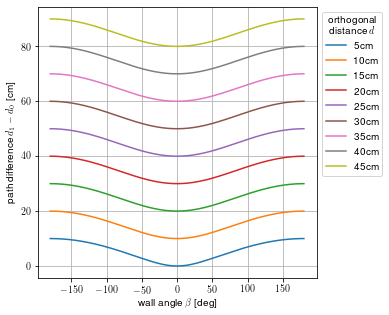

In [16]:
from simulation import get_delta

d0 = 5  # [cm]
d_arr = np.arange(5, 50, step=5)
beta_arr = np.linspace(-np.pi, np.pi, 361)
delta_matrix = get_delta(d_arr[None, :], beta_arr[:, None], d0)

fig = plt.figure()
fig.set_size_inches(5, 5)
for j, d in enumerate(d_arr):
    plt.plot(beta_arr * 180 / np.pi, delta_matrix[:, j], label=f"{d}cm")
plt.xlabel("wall angle $\\beta$ [deg]")
plt.ylabel("path difference $d_1-d_0$ [cm]")
l = plt.legend(
    bbox_to_anchor=[1.0, 1.0], loc="upper left", title="orthogonal \n distance $d$"
)
plt.setp(l.get_title(), multialignment="center")
plt.grid()

saved as plots/theory_distances.pdf


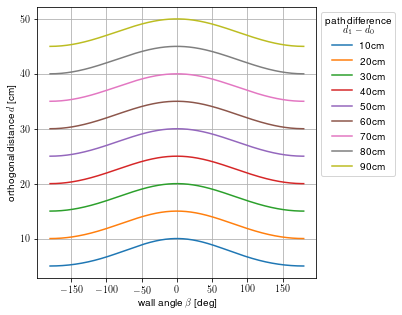

In [17]:
import matplotlib as mpl

mpl.rc("text", usetex=True)

from plotting_tools import save_fig
from simulation import get_orthogonal_distance

d0 = 5
delta_arr = np.arange(10, 100, step=10)
beta_arr = np.linspace(-np.pi, np.pi, 361)
d_matrix = get_orthogonal_distance(delta_arr, beta_arr, d0)

fig = plt.figure()
fig.set_size_inches(5, 5)
for j, d in enumerate(delta_arr):
    plt.plot(beta_arr * 180 / np.pi, d_matrix[:, j], label=f"{d}cm")
plt.xlabel("wall angle $\\beta$ [deg]")
plt.ylabel("orthogonal distance $d$ [cm]")
plt.grid(which="both")
l = plt.legend(
    bbox_to_anchor=[1.0, 1.0], loc="upper left", title="path difference \n $d_1 - d_0$"
)
plt.setp(l.get_title(), multialignment="center")
save_fig(fig, "plots/theory_distances.png")

## Noise study

All below depends on the nominal distance from the wall. We could make median performance vs. distance error and distance from wall plots, and repeat the same plot at different amplitude noises.

Preliminary studies:

- Find correct parameters for attenuation and wall loss, given our experimental data. Will be different from wall to wall! We can get different wall estimate from pyroomacoustics. 

Noise sensitivity plots:

- Add noise on "where" we measure: We think we are at d, but actually measure at d+epsilon. Or we think we are at theta, but actually measure at theta+epsilon. Both lead to an error in path length, so we can add noise on the path length and then translate that noise to theta and/or distance errrors (on separate y labels)

- Add noise on amplitudes. Check how high this is in practice for different settings (with/without motors, hovering or fixed, different windowing techniques, with/without interpolation, etc.)

Separate plot: 

- Add noise on frequencies to make them non-uniform (but known)

saved as plots/simulation/noise_study.pdf


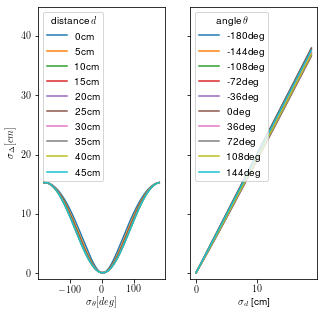

In [18]:
from simulation import get_deltas_from_global

mic_idx = 3
frequencies = np.linspace(1000, 5000, 100)
distances_cm = np.arange(50, step=5)
yaw_deg = np.arange(-180, 180)

sigmas_distance = np.arange(20)
sigmas_yaw = np.arange(-180, 180)

fig, axs = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(5, 5)
for d in distances_cm[:: len(distances_cm) // 10]:
    delta, d0 = get_deltas_from_global(0, d, mic_idx)
    delta_noisy, d0 = get_deltas_from_global(sigmas_yaw, d, mic_idx)
    sigmas_delta = 1e2 * abs(delta - delta_noisy)
    axs[0].plot(sigmas_yaw, sigmas_delta, label=f"{d}cm")
axs[0].set_xlabel("$\\sigma_\\theta [deg]$")
axs[0].set_ylabel("$\\sigma_\\Delta [cm]$")
axs[0].legend(loc="upper left", title="distance $d$")

for yaw in yaw_deg[:: len(yaw_deg) // 10]:
    delta, d0 = get_deltas_from_global(yaw, 0, mic_idx)
    delta_noisy, d0 = get_deltas_from_global(yaw, sigmas_distance, mic_idx)
    sigmas_delta = 1e2 * abs(delta - delta_noisy)
    axs[1].plot(sigmas_distance, sigmas_delta, label=f"{yaw}deg")
axs[1].set_xlabel("$\\sigma_d$ [cm]")
axs[1].legend(loc="upper left", title="angle $\\theta$")
axs[1].set_ylim(-1, 45)
save_fig(fig, "plots/simulation/noise_study.pdf")

## frequency slices

In [32]:
labels = {
    "fft": "FFT method",
    "cost": "optimization method",
    "sigmadelta": "delta noise $\sigma_\\Delta$ [cm]",
    "sigmay": "amplitude noise $\sigma_y$ [-]",
    "distance": "distance $d$ [cm]",
    np.nanstd: "error std",
    np.nanmedian: "median error",
    np.nanmean: "mean error",
}


def pcolorfast_custom(ax, xs, ys, values, verbose=False, **kwargs):
    """ pcolorfast with gray for nan and centered xticks and yticks. 
    """
    import matplotlib

    current_cmap = matplotlib.cm.get_cmap()
    current_cmap.set_bad(color="gray")

    assert values.shape == (len(ys), len(xs))

    dx = xs[1] - xs[0]  # assumes uniform samples
    dy = ys[1] - ys[0]
    try:
        im = ax.pcolorfast(xs, ys, values, **kwargs)
        yticks = ys + dy / 2
        xticks = xs + dx / 2
        ax.set_xticks(xticks)
        ax.set_xticklabels(xs)
        ax.set_yticks(yticks)
        ax.set_yticklabels(ys)
        extent = [xs[0], xs[-1] + dx, ys[0], ys[-1] + dy]
        im.set_extent(extent)
    except:
        print("Warning: problem with dimensions in pcolorfast (bug by matplotlib)")
        im = ax.pcolorfast(list(xs)+[xs[-1]+dx], list(ys)+[ys[-1]+dy], values, **kwargs)
    return im


def plot_error_distance(
    sub_df, column, name, log=False, aggfunc=np.nanmedian, vmin=None, vmax=None
):
    from plotting_tools import add_colorbar

    table = pd.pivot_table(
        sub_df,
        values="error",
        index=["method", column],
        columns="distance",
        aggfunc=aggfunc,
    )
    nonzero_values = table.values[table.values > 0]
    if vmin is None and len(nonzero_values):
        vmin = np.min(nonzero_values)
    if vmax is None and len(nonzero_values):
        vmax = np.max(nonzero_values)

    fig, axs = plt.subplots(1, len(sub_df.method.unique()), sharey=True, squeeze=False)
    fig.set_size_inches(5 * len(sub_df.method.unique()), 5)
    for i, (method, df) in enumerate(table.groupby("method")):
        index = df.index.get_level_values(column).values
        distances = df.columns.values
        if log:
            im = pcolorfast_custom(
                axs[0, i],
                distances,
                index,
                np.log10(df.values),
                vmin=np.log10(vmin),
                vmax=np.log10(vmax),
            )
        else:
            im = pcolorfast_custom(
                axs[0, i], distances, index, df.values, vmin=vmin, vmax=vmax
            )
        axs[0, i].set_xlabel("distance $d$ [cm]")
        axs[0, i].set_title(labels[method])
    add_colorbar(fig, axs[0, -1], im, title=f"{labels[aggfunc]} [cm]")
    axs[0, 0].set_ylabel(name.replace("_", " "))
    return fig, axs

In [33]:
from pandas_utils import filter_by_dict
from plotting_tools import save_fig

# TODO(FD) verify that below holds with a different gain too.

def get_cos_amplitudes(distances_cm):
    from simulation import WALL_ABSORPTION, GAIN
    from simulation import get_deltas_from_global
    from generate_simulation_results import YAW_DEG, MIC_IDX
    
    distances_cm = results_df.distance.unique()
    deltas_m, d0 = get_deltas_from_global(
        distances_cm=distances_cm, mic_idx=MIC_IDX, yaw_deg=YAW_DEG
    )
    alpha0 = 1 / (4 * np.pi * d0)
    alpha1 = (1 - WALL_ABSORPTION) / (4 * np.pi * (deltas_m + d0))
    cos_amplitudes = GAIN * 2 * alpha0 * alpha1
    return cos_amplitudes


def plot_cos_amplitudes(axs, results_df):
    distances_cm = results_df.distance.unique()
    cos_amplitudes = get_cos_amplitudes(distances_cm)
    for i, f in enumerate([1.0, 1.5, 2.0]):
        for ax in axs.flatten():
            ax.plot(
                distances_cm,
                f * cos_amplitudes,
                color=f"C{i}",
                label=f"$\\sigma_y=${f}$a(d)$",
            )
    [ax.set_ylim(None, results_df.sigmay.max()) for ax in axs.flatten()]
    axs[0, -1].legend(loc="upper right", framealpha=1.0)


def plot_cuts(results_df, category_label="sigmadelta", xlabel="distance", num_cuts=3):
    methods = results_df.method.unique()
    fig, axs = plt.subplots(1, len(methods), squeeze=False, sharey=True)
    fig.set_size_inches(5 * len(methods), 5)
    for i, (method, sub_df) in enumerate(results_df.groupby("method")):
        categories = sub_df[category_label].unique()

        idx = np.linspace(1, len(categories) - 1, num_cuts).astype(int)
        for category in categories[idx]:
            df = sub_df.loc[sub_df[category_label] == category]
            if not len(df):
                print(f"did not find {category} in {sub_df[category_label].unique()}")
                continue
            medians = df.groupby(xlabel).error.median()
            axs[0, i].plot(medians.index, medians.values, marker="o")
        # axs[0, i].set_yscale('log')
        axs[0, i].set_title(f"{labels[method]}")
        axs[0, i].set_xlabel(labels[xlabel])  # ('distance $d$ [cm]')
        axs[0, i].legend(np.round(categories[idx], 1), title=labels[category_label])
    axs[0, 0].set_ylabel("median error [cm]")
    return fig, axs

saved as plots/simulation/amplitude_noise_median.pdf
saved as plots/simulation/amplitude_noise_cost_median.pdf
saved as plots/simulation/amplitude_noise_cost_std.pdf
saved as plots/simulation/amplitude_noise_cost_slice.pdf
saved as plots/simulation/amplitude_noise_fft_median.pdf
saved as plots/simulation/amplitude_noise_fft_std.pdf
saved as plots/simulation/amplitude_noise_fft_slice.pdf


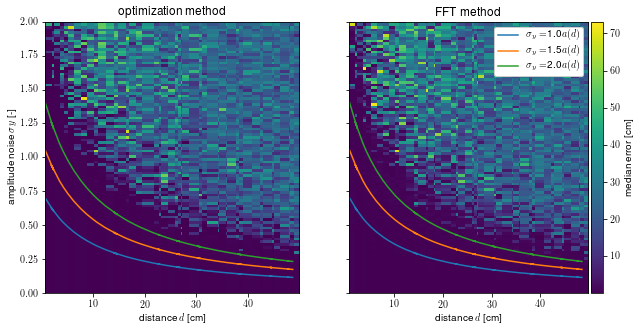

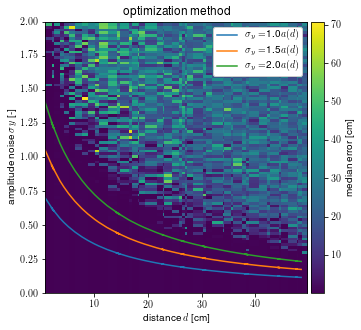

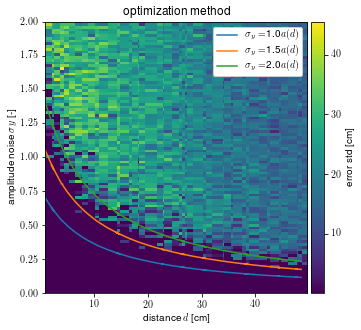

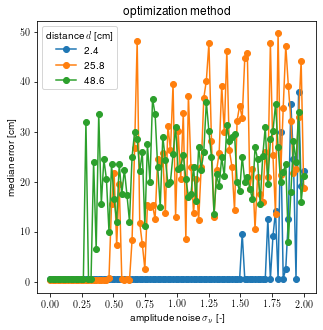

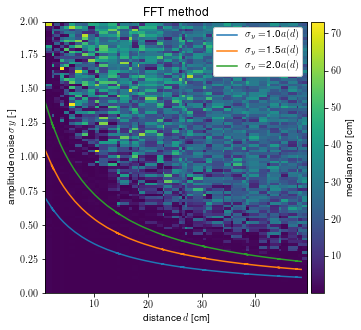

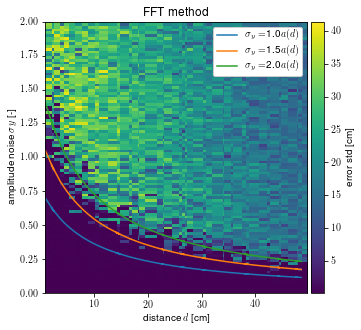

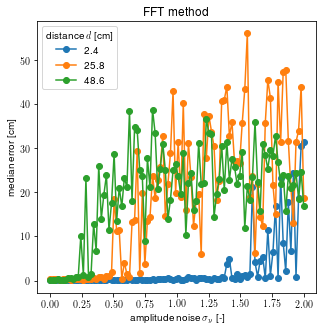

In [34]:
name = "amplitude_noise"
results_df = pd.read_pickle(f"results/simulation/{name}.pkl")

fig, axs = plot_error_distance(
    results_df, column="sigmay", name=name + " $\\sigma_y$ [-]", aggfunc=np.nanmedian
)
plot_cos_amplitudes(axs, results_df)
save_fig(fig, f"plots/simulation/{name}_median.pdf")
for method, sub_df in results_df.groupby("method"):
    fig, axs = plot_error_distance(
        sub_df, column="sigmay", name=name + " $\\sigma_y$ [-]", aggfunc=np.nanmedian
    )
    plot_cos_amplitudes(axs, results_df)
    save_fig(fig, f"plots/simulation/{name}_{method}_median.pdf")

    fig, axs = plot_error_distance(
        sub_df, column="sigmay", name=name + " $\\sigma_y$ [-]", aggfunc=np.nanstd
    )
    plot_cos_amplitudes(axs, results_df)
    save_fig(fig, f"plots/simulation/{name}_{method}_std.pdf")

    fig, axs = plot_cuts(sub_df, category_label="distance", xlabel="sigmay", num_cuts=3)
    save_fig(fig, f"plots/simulation/{name}_{method}_slice.pdf")

saved as plots/simulation/delta_noise_median.pdf
saved as plots/simulation/delta_noise_std.pdf
saved as plots/simulation/delta_noise_cost_median.pdf
saved as plots/simulation/delta_noise_cost_std.pdf
saved as plots/simulation/delta_noise_fft_median.pdf
saved as plots/simulation/delta_noise_fft_std.pdf


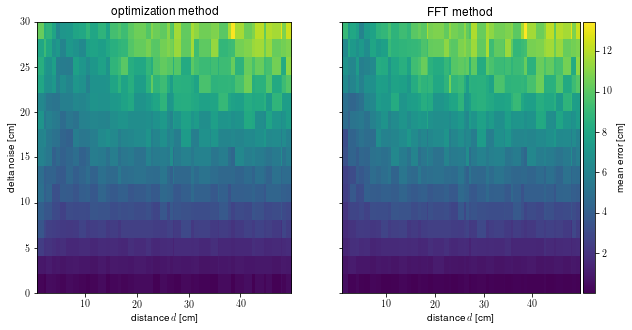

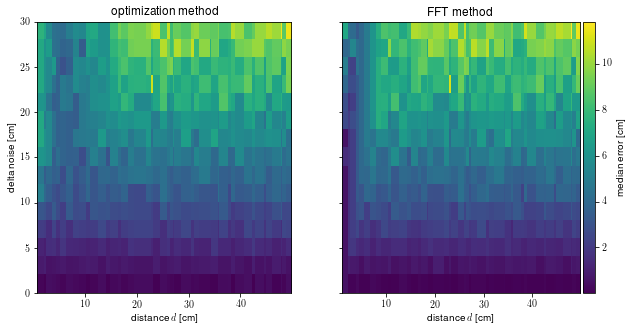

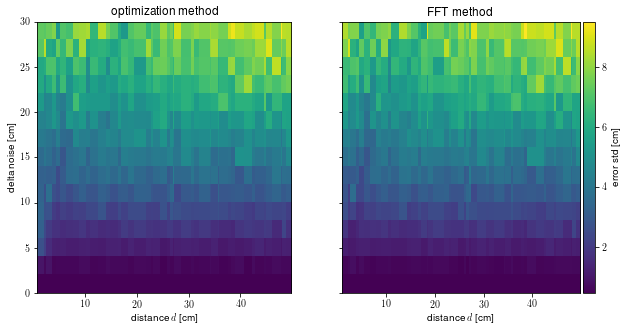

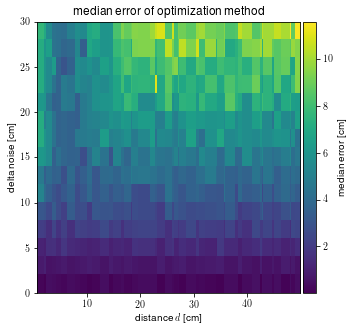

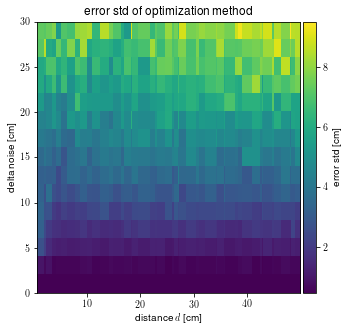

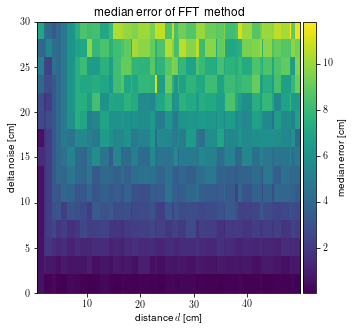

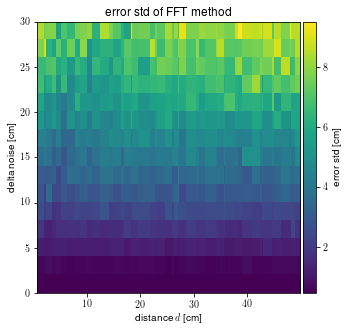

In [35]:
# name = 'delta_noise_high'
name = "delta_noise"
results_df = pd.read_pickle(f"results/simulation/{name}.pkl")

fig, axs = plot_error_distance(
    results_df, column="sigmadelta", name=name + " [cm]", aggfunc=np.nanmean
)
#save_fig(fig, f"plots/simulation/{name}_median.pdf")
fig, axs = plot_error_distance(
    results_df, column="sigmadelta", name=name + " [cm]", aggfunc=np.nanmedian
)
save_fig(fig, f"plots/simulation/{name}_median.pdf")
fig, axs = plot_error_distance(
    results_df, column="sigmadelta", name=name + " [cm]", aggfunc=np.nanstd
)
save_fig(fig, f"plots/simulation/{name}_std.pdf")

for method, sub_df in results_df.groupby("method"):

    fig, axs = plot_error_distance(
        sub_df, column="sigmadelta", name=name + " [cm]", aggfunc=np.nanmedian
    )
    axs[0, 0].set_title(f"median error of {labels[method]}")
    save_fig(fig, f"plots/simulation/{name}_{method}_median.pdf")

    fig, axs = plot_error_distance(
        sub_df, column="sigmadelta", name=name + " [cm]", aggfunc=np.nanstd
    )
    axs[0, 0].set_title(f"error std of {labels[method]}")
    save_fig(fig, f"plots/simulation/{name}_{method}_std.pdf")

saved as plots/simulation/delta_noise_cost_distance_cuts.pdf
saved as plots/simulation/delta_noise_cost_delta_cuts.pdf
saved as plots/simulation/delta_noise_fft_distance_cuts.pdf
saved as plots/simulation/delta_noise_fft_delta_cuts.pdf


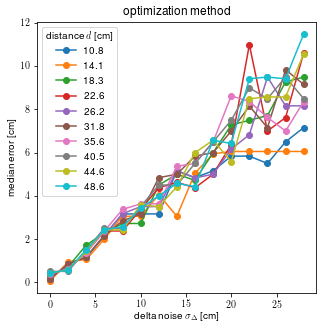

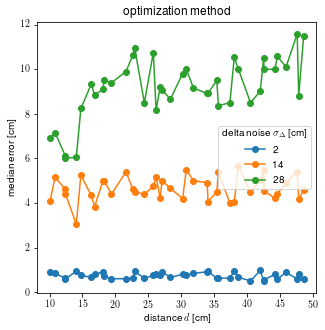

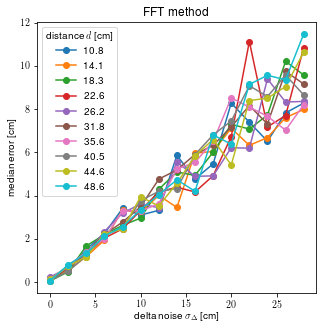

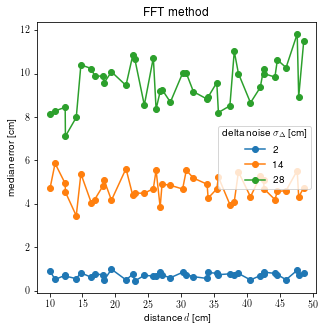

In [36]:
name = "delta_noise"
results_df = pd.read_pickle(f"results/simulation/{name}.pkl")
for method, sub_df in results_df.groupby("method"):
    sub_df = sub_df.loc[sub_df.distance >= 10]
    fig, axs = plot_cuts(
        sub_df, category_label="distance", xlabel="sigmadelta", num_cuts=10
    )
    save_fig(fig, f"plots/simulation/{name}_{method}_distance_cuts.pdf")

    fig, axs = plot_cuts(
        sub_df, category_label="sigmadelta", xlabel="distance", num_cuts=3
    )
    save_fig(fig, f"plots/simulation/{name}_{method}_delta_cuts.pdf")

saved as plots/simulation/frequency_noise_cost_median.pdf
saved as plots/simulation/frequency_noise_cost_std.pdf
saved as plots/simulation/frequency_noise_fft_median.pdf
saved as plots/simulation/frequency_noise_fft_std.pdf


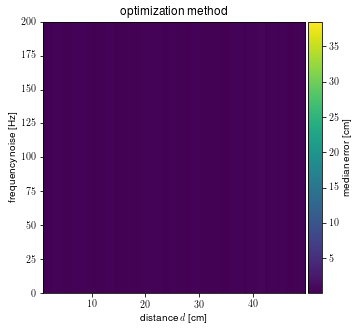

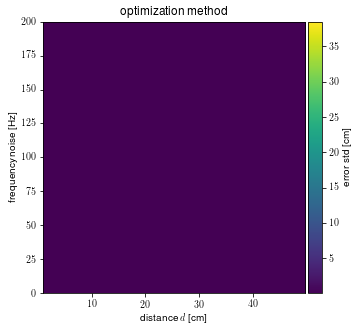

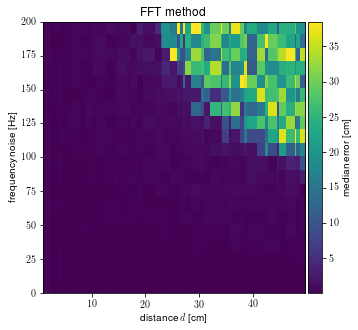

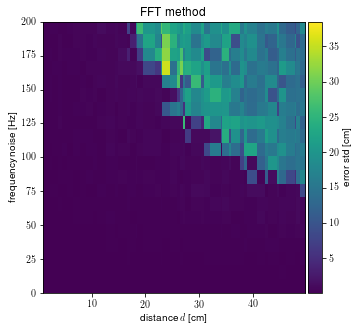

In [24]:
name = "frequency_noise"
results_df = pd.read_pickle(f"results/simulation/{name}.pkl")
vmin = results_df.error.min() / 2
vmax = results_df.error.max() / 2
for method, sub_df in results_df.groupby("method"):
    fig, axs = plot_error_distance(
        sub_df,
        column="sigmaf",
        name=name + " [Hz]",
        aggfunc=np.nanmedian,
        vmin=vmin,
        vmax=vmax,
    )
    save_fig(fig, f"plots/simulation/{name}_{method}_median.pdf")
    fig, axs = plot_error_distance(
        sub_df,
        column="sigmaf",
        name=name + " [Hz]",
        aggfunc=np.nanstd,
        vmin=vmin,
        vmax=vmax,
    )
    save_fig(fig, f"plots/simulation/{name}_{method}_std.pdf")

plotting 0.1
saved as plots/simulation/joint_noise_cost_0-1_median.pdf
saved as plots/simulation/joint_noise_fft_0-1_median.pdf
plotting 0.3
saved as plots/simulation/joint_noise_cost_0-3_median.pdf
saved as plots/simulation/joint_noise_fft_0-3_median.pdf
plotting 0.5
saved as plots/simulation/joint_noise_cost_0-5_median.pdf
saved as plots/simulation/joint_noise_fft_0-5_median.pdf


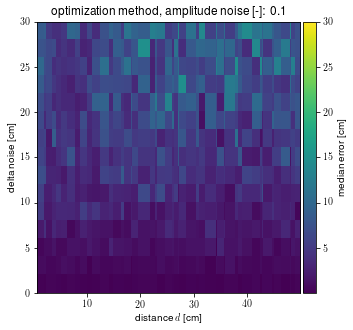

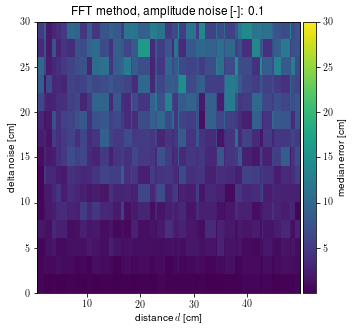

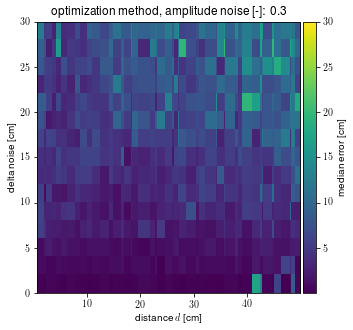

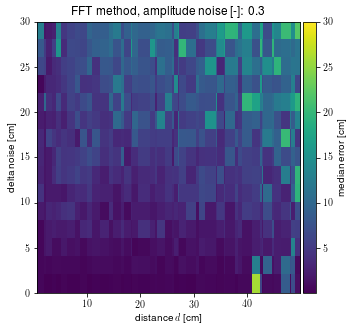

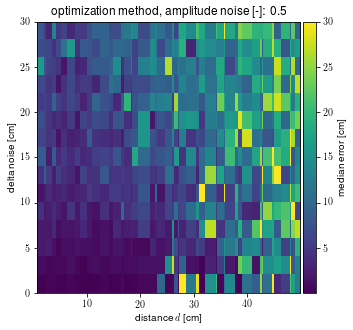

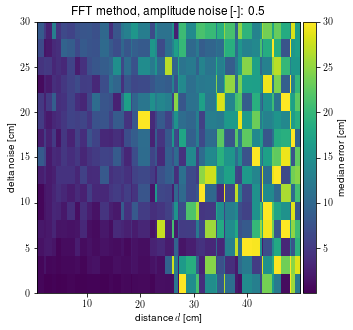

In [25]:
name = "joint_noise"
results_df = pd.read_pickle(f"results/simulation/{name}.pkl")

chosen_sigmas = results_df.sigmay.unique()
chosen_sigmas = chosen_sigmas[:: len(chosen_sigmas) // 3]

for sigma_y in chosen_sigmas:
    print("plotting", sigma_y)

    sub_df = filter_by_dict(results_df, {"sigmay": sigma_y})
    for method, sub_df in sub_df.groupby("method"):
        # fig, axs = plot_error_distance(sub_df, column='sigmadelta', name='delta noise', aggfunc=np.nanstd)
        # fig.suptitle(f'amplitude noise: {sigma_y}')
        fig, axs = plot_error_distance(
            sub_df,
            column="sigmadelta",
            name="delta noise [cm]",
            aggfunc=np.nanmedian,
            vmax=30,
        )
        axs[0, 0].set_title(f"{labels[method]}, amplitude noise [-]: {sigma_y}")
        save_fig(
            fig,
            f'plots/simulation/{name}_{method}_{str(sigma_y).replace(".","-")}_median.pdf',
        )

## distance slices

In [26]:
def plot_error_gamma(
    sub_df, column, name, log=False, aggfunc=np.nanmedian, vmin=None, vmax=None, logy=False,
    ax=None, fig=None, colorbar=True
):

    table = pd.pivot_table(
        sub_df,
        values="error",
        index=["method", column],
        columns="gamma",
        aggfunc=aggfunc,
    )
    nonzero_values = table.values[table.values > 0]
    if vmin is None and len(nonzero_values):
        vmin = np.min(nonzero_values)
    if vmax is None and len(nonzero_values):
        vmax = np.max(nonzero_values)

    if ax is None:
        fig, ax = plt.subplots()
        fig.set_size_inches(5, 5)

    ys = table.index.get_level_values(column).values
    #print(column, ys)
    if logy: 
        ys = np.log10(ys)
    gammas = table.columns.values
    if log:
        im = pcolorfast_custom(
            ax,
            gammas,
            ys,
            np.log10(table.values),
            vmin=np.log10(vmin),
            vmax=np.log10(vmax),
        )
    else:
        im = pcolorfast_custom(ax, gammas, ys, table.values, vmin=vmin, vmax=vmax)
    ax.set_xlabel("approach angle $\\gamma$ [deg]")
    ax.set_title(labels[method])
    if colorbar:
        from plotting_tools import add_colorbar
        add_colorbar(fig, ax, im, title=f"{labels[aggfunc]} [deg]")
    ax.set_ylabel(name.replace("_", " "))
    return fig, ax

saved as plots/simulation/angle_noiseless_cost_median.pdf
saved as plots/simulation/angle_noiseless_fft_median.pdf


,gamma,startdistance,frequency,sigmarelative,sigmay,method,error,counter
0,4.085110,53.837542,1000.0,0,0,fft,30.383177,0
2,4.085110,57.917724,1000.0,0,0,fft,30.383177,1
4,4.085110,51.124805,1000.0,0,0,fft,30.383177,2
6,4.085110,58.496159,1000.0,0,0,fft,30.383177,3
8,4.085110,51.557144,1000.0,0,0,fft,30.383177,4
...,...,...,...,...,...,...,...,...
3590,89.793449,58.958063,5000.0,0,0,fft,3.297950,5
3592,89.793449,59.589057,5000.0,0,0,fft,5.695019,6
3594,89.793449,49.853997,5000.0,0,0,fft,3.297950,7
3596,89.793449,47.861726,5000.0,0,0,fft,3.297950,8


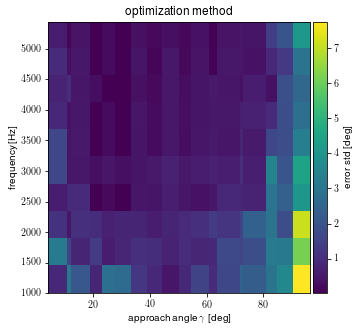

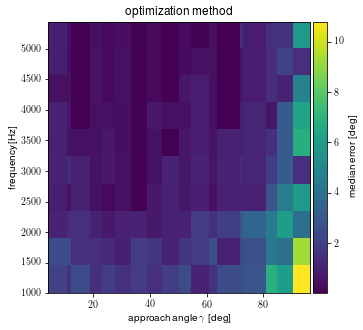

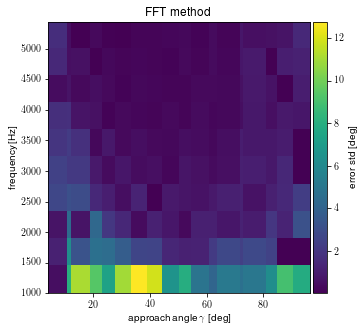

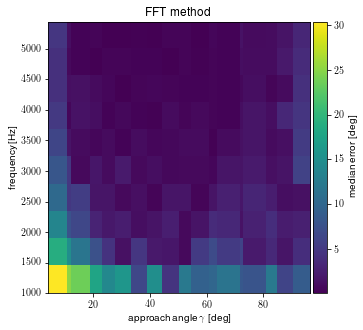

In [27]:
name = "angle_noiseless"
results_df = pd.read_pickle(f"results/simulation/{name}.pkl")

for method, sub_df in results_df.groupby("method"):
    fig, ax = plot_error_gamma(
        sub_df, column="frequency", name="frequency [Hz]", aggfunc=np.nanstd
    )
    #save_fig(fig, f"plots/simulation/{name}_{method}_std.pdf")
    fig, ax = plot_error_gamma(
        sub_df, column="frequency", name="frequency [Hz]", aggfunc=np.nanmedian
    )
    save_fig(fig, f"plots/simulation/{name}_{method}_median.pdf")
sub_df

saved as plots/simulation/angle_relative_noise_cost_median.pdf
saved as plots/simulation/angle_relative_noise_fft_median.pdf


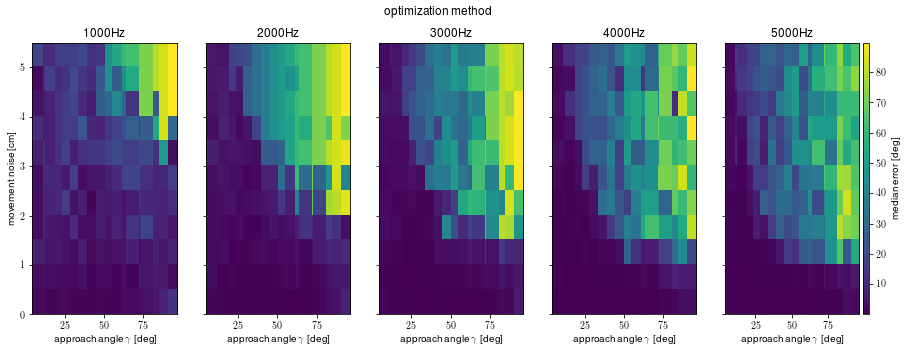

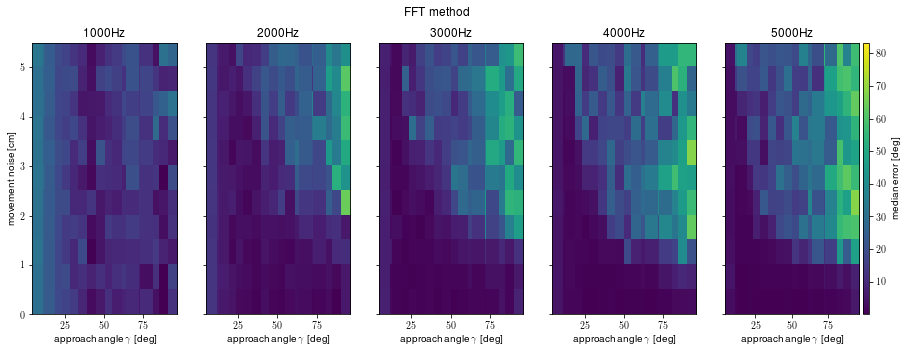

In [28]:
def plot_all_frequencies(name, logy=False, column="", column_name=""):
    results_df = pd.read_pickle(f"results/simulation/{name}.pkl")
    for method, method_df in results_df.groupby(["method"]):
        n_freqs = len(method_df.frequency.unique())
        fig, axs = plt.subplots(1, n_freqs, sharey=True)
        fig.set_size_inches(3*n_freqs, 5)
        
        vmin = method_df.error.min()
        vmax = method_df.error.max()
        
        for i, (frequency, sub_df) in enumerate(method_df.groupby("frequency")):
            if i < n_freqs-1:
                colorbar = False
            else:
                colorbar=True
                
            plot_error_gamma(
                sub_df, column=column, name=column_name, aggfunc=np.nanmedian, 
                logy=logy,
                vmin=vmin, vmax=vmax,
                colorbar=colorbar,
                ax=axs[i], fig=fig
            )
            if i > 0:
                axs[i].set_ylabel('')
            axs[i].set_title(f'{frequency:.0f}Hz')
        fig.suptitle(labels[method])
        save_fig(fig, f"plots/simulation/{name}_{method}_median.pdf")

name = "angle_relative_noise"
plot_all_frequencies(name, column="sigmarelative", column_name="movement noise [cm]")

saved as plots/simulation/angle_amplitude_noise_cost_median.pdf
saved as plots/simulation/angle_amplitude_noise_fft_median.pdf


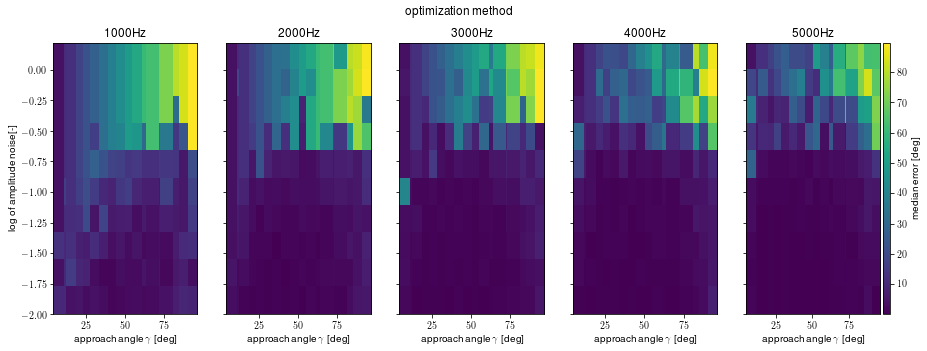

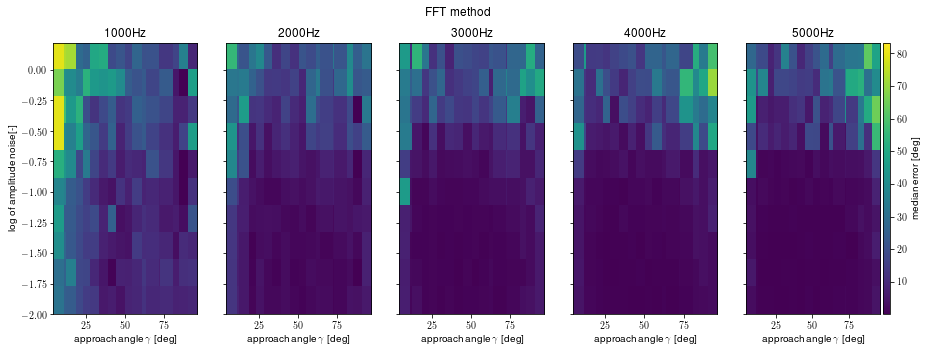

In [29]:
name = "angle_amplitude_noise"
plot_all_frequencies(name, logy=True, column="sigmay", column_name="log of amplitude noise[-]")

saved as plots/simulation/angle_joint_noise_3000_cost_median.pdf
saved as plots/simulation/angle_joint_noise_3000_fft_median.pdf


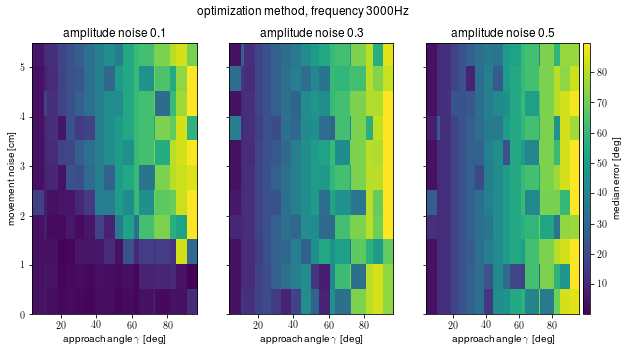

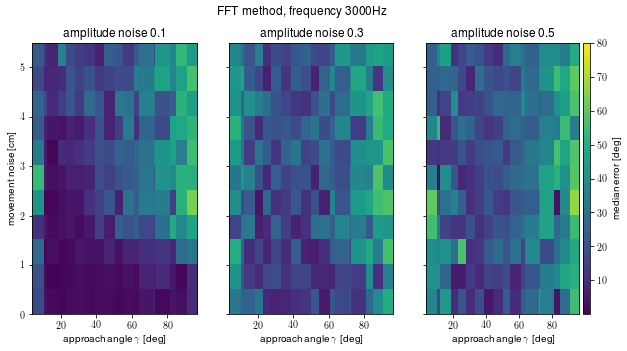

In [30]:
name = "angle_joint_noise"
results_df = pd.read_pickle(f"results/simulation/{name}.pkl")

f = 3000
for (method,frequency), freq_df in results_df.groupby(['method', 'frequency']):
    if frequency != f:
        continue
    n_noises = len(freq_df.sigmay.unique())
    vmin = freq_df.error.min()
    vmax = freq_df.error.max()
    fig, axs = plt.subplots(1, n_noises, sharey=True) 
    for i, (sigmay, sub_df) in enumerate(freq_df.groupby('sigmay')):
        if i < n_noises - 1:
            colorbar = False
        else:
            colorbar = True
        plot_error_gamma(
            sub_df, column="sigmarelative", name="movement noise [cm]", aggfunc=np.nanmedian,
            ax=axs[i], fig=fig, colorbar=colorbar, vmin=vmin, vmax=vmax
        )
        axs[i].set_ylabel('')
        axs[i].set_title(f'amplitude noise {sigmay}')
    axs[0].set_ylabel('movement noise [cm]')
    fig.suptitle(f"{labels[method]}, frequency {frequency:.0f}Hz")
    save_fig(fig, f"plots/simulation/{name}_{frequency:.0f}_{method}_median.pdf")
#plot_all_frequencies(name, logy=False, column="sigmarelative", column_name="amplitude noise[-]")